In [169]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import tqdm
import gc
import copy

from collections import defaultdict
import itertools

import plotly as ply
ply.io.renderers.default="notebook"

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import sklearn as skl
from sklearn.neighbors import KernelDensity

import gridData
from gridData import Grid

# Analysis of last 200 frames 

In [6]:
pmeVolData_neg200mV=Grid("CX26_neg200mV_last40ns_PME.dx")
pmeVolData_pos200mV=Grid("p200mV.PME.dx")
pmeVolData_neg200mV

<<class 'gridData.core.Grid'> with (128, 128, 168) bins>

In [4]:
dir(pmeVolData)

['_Grid__interpolated',
 '_Grid__interpolation_spline_order',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_export_dx',
 '_export_python',
 '_exporters',
 '_get_exporter',
 '_get_loader',
 '_guess_format',
 '_interpolationFunctionFactory',
 '_len_edges',
 '_load_cpp4',
 '_load_dx',
 '_load_plt',
 '_load_python',
 '_loaders',
 '_map_edges',
 '_max_edges',
 '_midpoints',
 '_min_edges',
 '_update',
 'centers',
 'check_compatible',
 'default_format',
 'delta',
 'edges',
 'export'

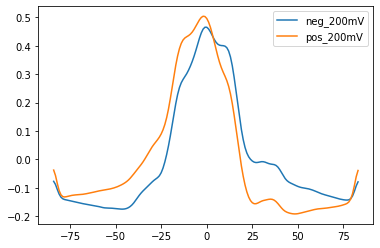

In [8]:
kb=8.617333262E-5
tSim=310.15
kbT=kb*tSim
sns.lineplot(np.arange(168)-168/2,
             kbT*np.mean(pmeVolData_neg200mV.grid,axis=(0,1)),
             label='neg_200mV')
sns.lineplot(np.arange(168)-168/2,
             kbT*np.mean(pmeVolData_pos200mV.grid,axis=(0,1)),
             label='pos_200mV')
plt.show()

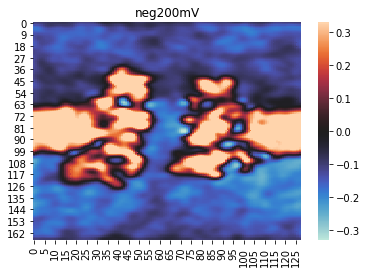

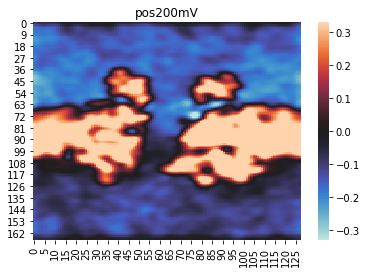

In [49]:
negCrossSect=np.rot90(kbT*pmeVolData_neg200mV.grid[:,64,:])
vcut=np.abs(np.min([
    np.max(negCrossSect),
    np.min(negCrossSect)
]))
sns.heatmap(negCrossSect,center=0,
            vmin=-vcut,vmax=vcut
           )
plt.title('neg200mV')
plt.show()

posCrossSect=np.rot90(kbT*pmeVolData_pos200mV.grid[:,64,:])
vcut=np.abs(np.min([
    np.max(negCrossSect),
    np.min(negCrossSect)
]))
sns.heatmap(posCrossSect,center=0,
            vmin=-vcut,vmax=vcut
           )
plt.title('pos200mV')
plt.show()

In [54]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 2AEE-9105

 Directory of C:\Users\wesle\Documents\Connexin\CX26_PME_Analysis

04/27/2020  12:55 PM    <DIR>          .
04/27/2020  12:55 PM    <DIR>          ..
04/27/2020  09:49 AM    <DIR>          .ipynb_checkpoints
04/27/2020  08:58 AM        24,693,911 CX26_neg200mV_last40ns_PME.dx
04/27/2020  12:29 PM        19,533,535 n200mV.cAMP_Density.dx
04/27/2020  12:28 PM        27,679,141 n200mV.CLA_Density.dx
04/24/2020  02:00 PM       571,732,636 n200mV.last_200frames.dcd
04/27/2020  12:28 PM        26,735,824 n200mV.POT_Density.dx
04/27/2020  12:27 PM        22,230,969 p200mV.cAMP_Density.dx
04/27/2020  12:26 PM        27,765,319 p200mV.CLA_Density.dx
04/27/2020  09:21 AM       571,732,636 p200mV.last_200frames.imaged.dcd
04/27/2020  10:13 AM        24,701,175 p200mV.PME.dx
04/27/2020  12:25 PM        26,378,519 p200mV.POT_Density.dx
04/27/2020  12:55 PM           172,164 PME_Analysis_Notebook.ipynb
04/27/2020  08:58 AM            

In [94]:
densityMapDict={}
ionNameList=['POT','CLA','cAMP','Ion','protein']
simNameList=['p200mV','n200mV']
dataDir='.'
for simName in simNameList:
    for ionName in ionNameList:
        dictKey='.'.join([simName,ionName])
        fileName='.'.join([dictKey+'_Density','dx'])
        filePath='/'.join([dataDir,fileName])
        print("Loading %s; "%fileName,end="")
        densityMapDict[dictKey]=Grid(filePath)
        print(densityMapDict[dictKey].grid.shape,"volumetric grid loaded")

Loading p200mV.POT_Density.dx; (142, 142, 184) volumetric grid loaded
Loading p200mV.CLA_Density.dx; (142, 142, 184) volumetric grid loaded
Loading p200mV.cAMP_Density.dx; (153, 152, 195) volumetric grid loaded
Loading p200mV.Ion_Density.dx; (153, 152, 195) volumetric grid loaded
Loading p200mV.protein_Density.dx; (131, 138, 119) volumetric grid loaded
Loading n200mV.POT_Density.dx; (142, 142, 185) volumetric grid loaded
Loading n200mV.CLA_Density.dx; (142, 142, 186) volumetric grid loaded
Loading n200mV.cAMP_Density.dx; (154, 151, 194) volumetric grid loaded
Loading n200mV.Ion_Density.dx; (154, 151, 194) volumetric grid loaded
Loading n200mV.protein_Density.dx; (133, 132, 118) volumetric grid loaded


Constructing plots for p200mV.Ion
Constructing plots for p200mV.protein
Constructing plots for n200mV.Ion
Constructing plots for n200mV.protein


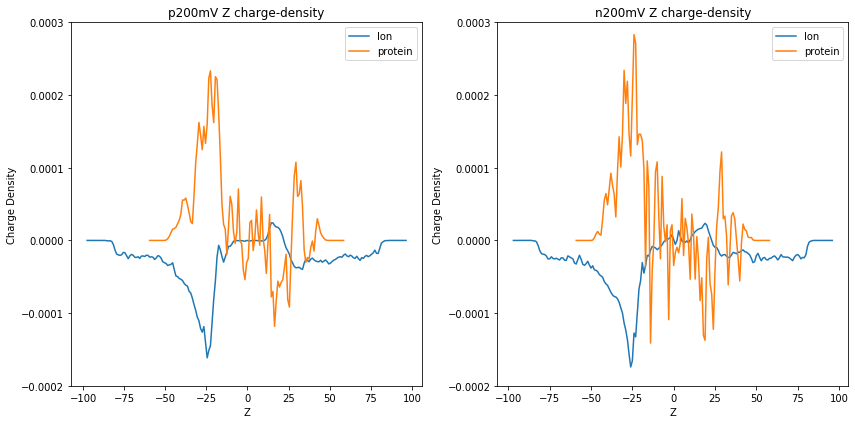

In [98]:
fig,axs=plt.subplots(
    nrows=1, #len(ionNameList)+1, #
    ncols=len(simNameList)
    )

fig.set_figwidth(12)
fig.set_figheight(
        6 #11.0*(len(ionNameList)+1)/len(simNameList)
    )

for iSim,simName in enumerate(simNameList):
    for iIon,ionName in enumerate(['Ion','protein']): #ionNameList):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        
        zDensity=np.mean(densityData,axis=(0,1))
        #zDensity=zDensity/np.sum(zDensity)
        #ax=axs[0][iSim]
        ax=axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=ionName,ax=ax)
        ax.set_ylim(-.0002,.0003)
        ax.set_title('{sim} Z charge-density'.format(sim=simName))
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density')
        
        #ymid=int(np.round(densityData.shape[1]/2.))
        #xzDensity=np.rot90(densityData[:,ymid,:])
        ##xzDensity=xzDensity/np.sum(xzDensity)
        #ax=axs[iIon+1][iSim]
        #sns.heatmap(xzDensity,vmin=0,ax=ax)
        #ax.set_title('{sim}.{ion} XZ charge-density'.format(
        #    sim=simName,ion=ionName))
        #ax.set_xlabel('X')
        #ax.set_ylabel('Z')
plt.tight_layout()
plt.show()

# Analysis of last 1000 frames

In [2]:
pmeVolData_neg200mV=Grid("n200mV.last_1000_frames.imaged.PME.dx")
pmeVolData_pos200mV=Grid("p200mV.last_1000_frames.imaged.PME.dx")
pmeVolData_neg200mV

<<class 'gridData.core.Grid'> with (128, 128, 168) bins>

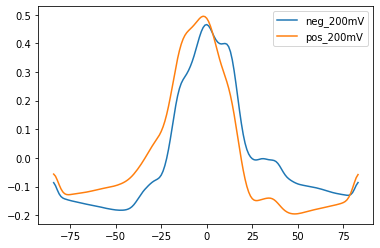

In [3]:
kb=8.617333262E-5
tSim=310.15
kbT=kb*tSim
sns.lineplot(np.arange(168)-168/2,
             kbT*np.mean(pmeVolData_neg200mV.grid,axis=(0,1)),
             label='neg_200mV')
sns.lineplot(np.arange(168)-168/2,
             kbT*np.mean(pmeVolData_pos200mV.grid,axis=(0,1)),
             label='pos_200mV')
plt.show()

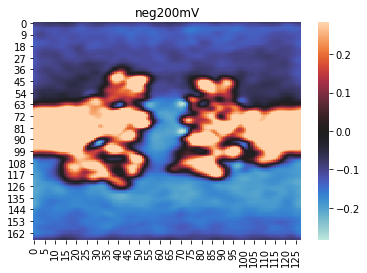

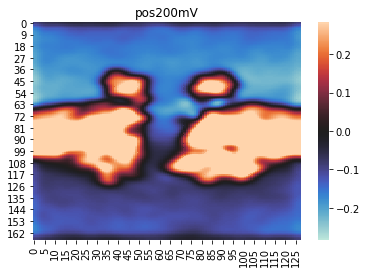

In [4]:
negCrossSect=np.rot90(kbT*pmeVolData_neg200mV.grid[:,64,:])
vcut=np.abs(np.min([
    np.max(negCrossSect),
    np.min(negCrossSect)
]))
sns.heatmap(negCrossSect,center=0,
            vmin=-vcut,vmax=vcut
           )
plt.title('neg200mV')
plt.show()

posCrossSect=np.rot90(kbT*pmeVolData_pos200mV.grid[:,64,:])
vcut=np.abs(np.min([
    np.max(negCrossSect),
    np.min(negCrossSect)
]))
sns.heatmap(posCrossSect,center=0,
            vmin=-vcut,vmax=vcut
           )
plt.title('pos200mV')
plt.show()

In [209]:
densityMapDict={}
ionNameList=['POT','CLA','cAMP','MGH','Ions','Protein','Lipid','Water','NonWater','Total']
simNameList=['p200mV','n200mV']
dataDir='.'
for simName in simNameList:
    for ionName in ionNameList:
        dictKey='.'.join([simName,ionName])
        fileName='.'.join([simName,'last_1000_frames','imaged',ionName+'_ChargeDensity','dx'])
        filePath='/'.join([dataDir,fileName])
        print("Loading %s; "%fileName,end="")
        densityMapDict[dictKey]=Grid(filePath)
        print(densityMapDict[dictKey].grid.shape,"volumetric grid loaded")

Loading p200mV.last_1000_frames.imaged.POT_ChargeDensity.dx; (143, 143, 185) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.CLA_ChargeDensity.dx; (143, 143, 184) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.cAMP_ChargeDensity.dx; (153, 153, 195) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.MGH_ChargeDensity.dx; (144, 144, 187) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.Ions_ChargeDensity.dx; (153, 153, 195) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.Protein_ChargeDensity.dx; (149, 143, 128) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.Lipid_ChargeDensity.dx; (176, 179, 97) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.Water_ChargeDensity.dx; (145, 145, 187) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.NonWater_ChargeDensity.dx; (187, 179, 195) volumetric grid loaded
Loading p200mV.last_1000_frames.imaged.Total_ChargeDensity.dx; (187, 179, 195) volumet

Constructing plots for p200mV.Ions
Constructing plots for p200mV.Protein
Constructing plots for p200mV.Lipid
Constructing plots for p200mV.Water
Constructing plots for p200mV.Total
Constructing plots for n200mV.Ions
Constructing plots for n200mV.Protein
Constructing plots for n200mV.Lipid
Constructing plots for n200mV.Water
Constructing plots for n200mV.Total


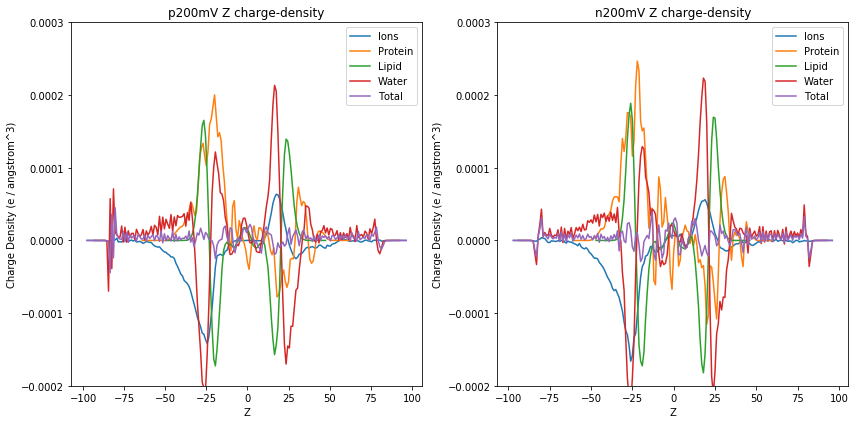

In [47]:
fig,axs=plt.subplots(
    nrows=1, #len(ionNameList)+1, #
    ncols=len(simNameList)
    )

fig.set_figwidth(12)
fig.set_figheight(
        6 #11.0*(len(ionNameList)+1)/len(simNameList)
    )

for iSim,simName in enumerate(simNameList):
    for iIon,ionName in enumerate(['Ions','Protein','Lipid','Water','Total']): #ionNameList):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        
        zDensity=np.mean(densityData,axis=(0,1))
        #zDensity=zDensity/np.sum(zDensity)
        #ax=axs[0][iSim]
        ax=axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=ionName,ax=ax)
        ax.set_ylim(-.0002,.0003)
        ax.set_title('{sim} Z charge-density'.format(sim=simName))
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density (e / angstrom^3)')
        
        #ymid=int(np.round(densityData.shape[1]/2.))
        #xzDensity=np.rot90(densityData[:,ymid,:])
        ##xzDensity=xzDensity/np.sum(xzDensity)
        #ax=axs[iIon+1][iSim]
        #sns.heatmap(xzDensity,vmin=0,ax=ax)
        #ax.set_title('{sim}.{ion} XZ charge-density'.format(
        #    sim=simName,ion=ionName))
        #ax.set_xlabel('X')
        #ax.set_ylabel('Z')
plt.tight_layout()
plt.show()

Constructing plots for p200mV.POT
Constructing plots for p200mV.CLA
Constructing plots for p200mV.cAMP
Constructing plots for p200mV.MGH
Constructing plots for p200mV.Ions
Constructing plots for n200mV.POT
Constructing plots for n200mV.CLA
Constructing plots for n200mV.cAMP
Constructing plots for n200mV.MGH
Constructing plots for n200mV.Ions


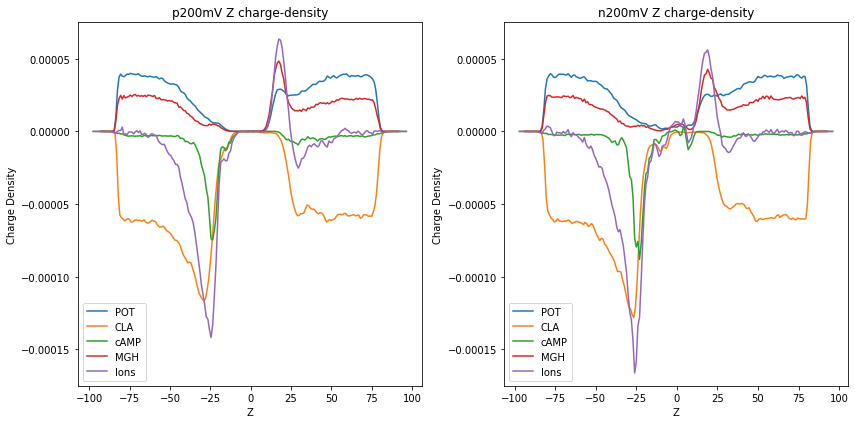

In [29]:
fig,axs=plt.subplots(
    nrows=1, #len(ionNameList)+1, #
    ncols=len(simNameList)
    )

fig.set_figwidth(12)
fig.set_figheight(
        6 #11.0*(len(ionNameList)+1)/len(simNameList)
    )

for iSim,simName in enumerate(simNameList):
    for iIon,ionName in enumerate(['POT','CLA','cAMP','MGH','Ions']): #ionNameList):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        
        zDensity=np.mean(densityData,axis=(0,1))
        #zDensity=zDensity/np.sum(zDensity)
        #ax=axs[0][iSim]
        ax=axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=ionName,ax=ax)
        ax.set_ylim(-.000175,.000075)
        ax.set_title('{sim} Z charge-density'.format(sim=simName))
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density (e / angstrom^3)')
        
        #ymid=int(np.round(densityData.shape[1]/2.))
        #xzDensity=np.rot90(densityData[:,ymid,:])
        ##xzDensity=xzDensity/np.sum(xzDensity)
        #ax=axs[iIon+1][iSim]
        #sns.heatmap(xzDensity,vmin=0,ax=ax)
        #ax.set_title('{sim}.{ion} XZ charge-density'.format(
        #    sim=simName,ion=ionName))
        #ax.set_xlabel('X')
        #ax.set_ylabel('Z')
plt.tight_layout()
plt.show()

Constructing plots for p200mV.Ions
Constructing plots for p200mV.Protein
Constructing plots for p200mV.Lipid
Constructing plots for p200mV.Water
Constructing plots for p200mV.Total
Constructing plots for n200mV.Ions
Constructing plots for n200mV.Protein
Constructing plots for n200mV.Lipid
Constructing plots for n200mV.Water
Constructing plots for n200mV.Total


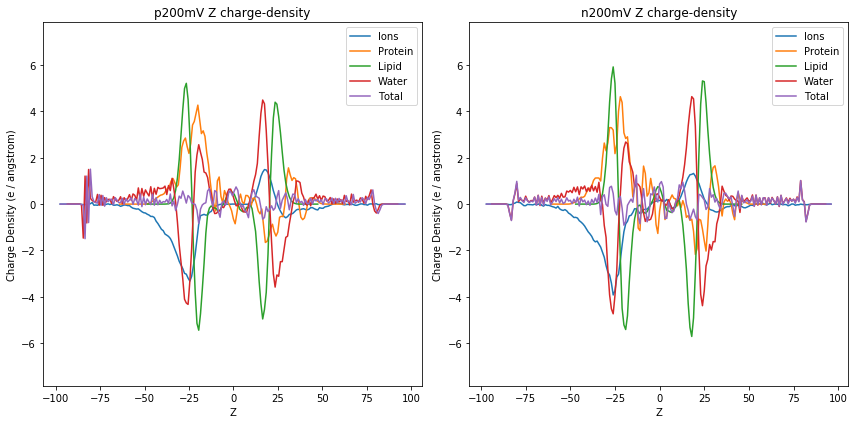

In [48]:
fig,axs=plt.subplots(
    nrows=1, #len(ionNameList)+1, #
    ncols=len(simNameList)
    )

fig.set_figwidth(12)
fig.set_figheight(
        6 #11.0*(len(ionNameList)+1)/len(simNameList)
    )

for iSim,simName in enumerate(simNameList):
    for iIon,ionName in enumerate(['Ions','Protein','Lipid','Water','Total']): #ionNameList):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        crossSectionArea=np.product(densityData.shape[:2])
        
        zDensity=np.mean(densityData,axis=(0,1))*crossSectionArea
        ax=axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=ionName,ax=ax)
        ax.set_ylim(-7.832, 7.832) #(-.00025*crossSectionArea,.00025*crossSectionArea)
        ax.set_title('{sim} Z charge-density'.format(sim=simName))
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density (e / angstrom)')
        
plt.tight_layout()
plt.show()

Constructing plots for p200mV.POT
Constructing plots for p200mV.CLA
Constructing plots for p200mV.cAMP
Constructing plots for p200mV.MGH
Constructing plots for p200mV.Ions
Constructing plots for n200mV.POT
Constructing plots for n200mV.CLA
Constructing plots for n200mV.cAMP
Constructing plots for n200mV.MGH
Constructing plots for n200mV.Ions


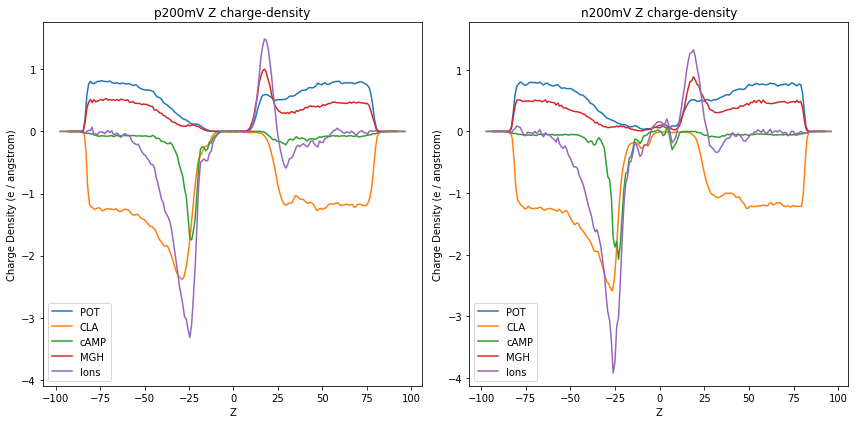

In [14]:
fig,axs=plt.subplots(
    nrows=1, #len(ionNameList)+1, #
    ncols=len(simNameList)
    )

fig.set_figwidth(12)
fig.set_figheight(
        6 #11.0*(len(ionNameList)+1)/len(simNameList)
    )

for iSim,simName in enumerate(simNameList):
    for iIon,ionName in enumerate(['POT','CLA','cAMP','MGH','Ions']): #ionNameList):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        crossSectionArea=np.product(densityData.shape[:2])
        
        zDensity=np.mean(densityData,axis=(0,1))*crossSectionArea
        ax=axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=ionName,ax=ax)
        ax.set_ylim(-.000175 * crossSectionArea,.000075 * crossSectionArea)
        ax.set_title('{sim} Z charge-density'.format(sim=simName))
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density (e / angstrom)')
plt.tight_layout()
plt.show()

Constructing plots for n200mV.Water
Constructing plots for p200mV.Water


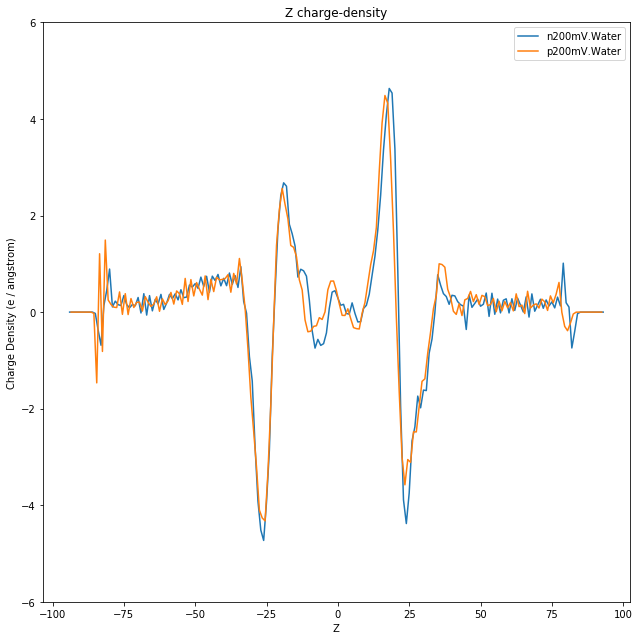

Constructing plots for n200mV.NonWater
Constructing plots for p200mV.NonWater


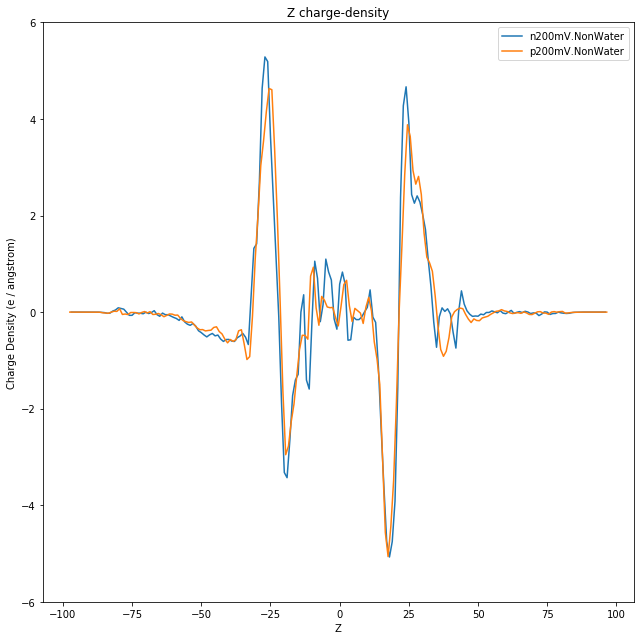

Constructing plots for n200mV.Total
Constructing plots for p200mV.Total


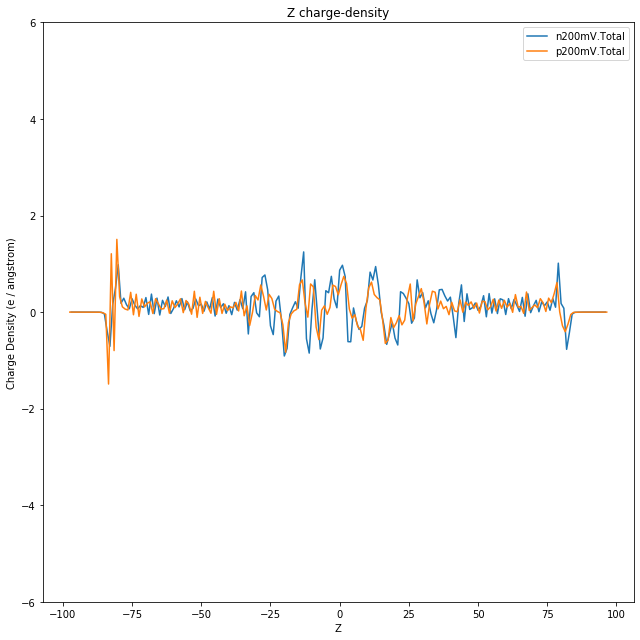

In [55]:

for iIon,ionName in enumerate(['Water','NonWater','Total']): #ionNameList):
    fig,axs=plt.subplots(
        nrows=1, #len(ionNameList)+1, #
        ncols=1 #len(simNameList)
        )

    fig.set_figwidth(9)
    fig.set_figheight(
           9 #11.0*(len(ionNameList)+1)/len(simNameList)
        )
    for iSim,simName in enumerate(['n200mV','p200mV']):
        print("Constructing plots for {sim}.{ion}".format(sim=simName,ion=ionName))
        dataKey='.'.join([simName,ionName])
        densityData=densityMapDict[dataKey].grid
        crossSectionArea=np.product(densityData.shape[:2])
        
        zDensity=np.mean(densityData,axis=(0,1))*crossSectionArea
        ax=axs #axs[iSim]
        sns.lineplot(
            x=np.arange(densityData.shape[2])-densityData.shape[2]/2,
            y=zDensity,
            label=dataKey,ax=ax)
        ax.set_ylim(-6, 6) #(-.00025*crossSectionArea,.00025*crossSectionArea)
        ax.set_title('Z charge-density')
        ax.set_xlabel('Z')
        ax.set_ylabel('Charge Density (e / angstrom)')
        
    plt.tight_layout()
    plt.show()

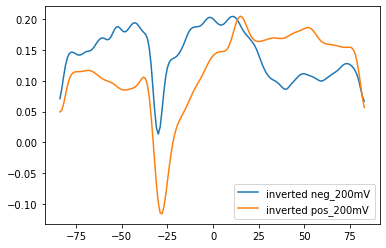

In [59]:
kb=8.617333262E-5
tSim=310.15
kbT=kb*tSim
xmid=int(np.round(pmeVolData_neg200mV.grid.shape[0]/2.))
ymid=int(np.round(pmeVolData_neg200mV.grid.shape[1]/2.))
sns.lineplot(np.arange(168)-168/2,
             -kbT*pmeVolData_neg200mV.grid[xmid,ymid,:],
             label='inverted neg_200mV')
xmid=int(np.round(pmeVolData_pos200mV.grid.shape[0]/2.))
ymid=int(np.round(pmeVolData_pos200mV.grid.shape[1]/2.))
sns.lineplot(np.arange(168)-168/2,
             -kbT*pmeVolData_pos200mV.grid[xmid,ymid,:],
             label='inverted pos_200mV')
plt.show()

In [294]:
pmeDict={}
dataDir='.'
for simName in ['n200mV','p200mV']:
    for pmeName in ['noncAMP','cAMP','ProteinLipid','Total']:
        dictKey='.'.join([simName,pmeName])
        filename='.'.join([simName,'last_1000_frames.imaged',pmeName+'_PME','dx'])
        filepath='/'.join([dataDir,filename])
        print('loading {dataFile};'.format(dataFile=filename),end=" ")
        pmeDict[dictKey]=Grid(filepath)
        print(pmeDict[dictKey].grid.shape,"volumetric data file loaded")
print("--- done loading data files ---")

loading n200mV.last_1000_frames.imaged.noncAMP_PME.dx; (128, 128, 168) volumetric data file loaded
loading n200mV.last_1000_frames.imaged.cAMP_PME.dx; (128, 128, 168) volumetric data file loaded
loading n200mV.last_1000_frames.imaged.ProteinLipid_PME.dx; (128, 128, 168) volumetric data file loaded
loading n200mV.last_1000_frames.imaged.Total_PME.dx; (128, 128, 168) volumetric data file loaded
loading p200mV.last_1000_frames.imaged.noncAMP_PME.dx; (128, 128, 168) volumetric data file loaded
loading p200mV.last_1000_frames.imaged.cAMP_PME.dx; (128, 128, 168) volumetric data file loaded
loading p200mV.last_1000_frames.imaged.ProteinLipid_PME.dx; (128, 128, 168) volumetric data file loaded
loading p200mV.last_1000_frames.imaged.Total_PME.dx; (128, 128, 168) volumetric data file loaded
--- done loading data files ---


In [291]:
simNameList=['p200mV','n200mV']
dataDir='.'

massDensityDict={}
pmeDict={}
massDensityNameList=['Solvent','cAMP']
for simName in simNameList:
    pmeName='.'.join([simName,'last_1000_frames','imaged','PME','dx'])
    pmePath='/'.join([dataDir,pmeName])
    print("loading {file};".format(file=pmeName),end="")
    pmeDict[simName]=Grid(pmePath)
    print(pmeDict[simName].grid.shape,"volumetric grid loaded")
    for massDensityName in massDensityNameList:
        dictKey='.'.join([simName,massDensityName])
        filename='.'.join([simName,'last_1000_frames',"imaged",
                           massDensityName+'_MassDensity','dx'])
        print("loading {file};".format(file=filename),end="")
        filepath='/'.join([dataDir,filename])
        massDensityDict[dictKey]=Grid(filepath)
        print(massDensityDict[dictKey].grid.shape,"volumetric grid loaded")

loading p200mV.last_1000_frames.imaged.PME.dx;(128, 128, 168) volumetric grid loaded
loading p200mV.last_1000_frames.imaged.Solvent_MassDensity.dx;(154, 154, 196) volumetric grid loaded
loading p200mV.last_1000_frames.imaged.cAMP_MassDensity.dx;(154, 154, 196) volumetric grid loaded
loading n200mV.last_1000_frames.imaged.PME.dx;(128, 128, 168) volumetric grid loaded
loading n200mV.last_1000_frames.imaged.Solvent_MassDensity.dx;(154, 153, 194) volumetric grid loaded
loading n200mV.last_1000_frames.imaged.cAMP_MassDensity.dx;(154, 153, 194) volumetric grid loaded


In [295]:
massDensityNameList=['Solvent','cAMP']
simNameList=['p200mV','n200mV']
dataDir='.'
resampledDensityDict={}
for simName in simNameList:
    pmeGrid=pmeDict[simName+'.Total']
    print('{sim} pme grid bounds:         '.format(sim=simName),
          pmeGrid.origin,pmeGrid.origin+pmeGrid.delta*pmeGrid.grid.shape,)
    
    for massDensityName in massDensityNameList:
        massKey=simName+'.'+massDensityName
        massDensityGrid=massDensityDict[massKey]

        print('{massDensity} mass density grid bounds:'.format(massDensity=massKey),
              massDensityGrid.origin,
              massDensityGrid.origin+massDensityGrid.delta*massDensityGrid.grid.shape)
        
        resampledDensityDict[massKey]=massDensityGrid.resample(pmeGrid)
        massDensity_on_pmeGrid=resampledDensityDict[massKey]
        print('{massDensity} mass density on pme grid bounds:'.format(massDensity=massKey),
              massDensity_on_pmeGrid.origin,
              massDensity_on_pmeGrid.origin+massDensity_on_pmeGrid.delta*massDensity_on_pmeGrid.grid.shape)

p200mV pme grid bounds:          [-59.7296 -59.595  -81.0299] [60.670272 60.533512 82.000156]
p200mV.Solvent mass density grid bounds: [-76.5 -76.5 -97.5] [77.5 77.5 98.5]
p200mV.Solvent mass density on pme grid bounds: [-59.7296 -59.595  -81.0299] [60.670272 60.533512 82.000156]
p200mV.cAMP mass density grid bounds: [-76.5 -76.5 -97.5] [77.5 77.5 98.5]
p200mV.cAMP mass density on pme grid bounds: [-59.7296 -59.595  -81.0299] [60.670272 60.533512 82.000156]
n200mV pme grid bounds:          [-59.7026 -59.5681 -81.1232] [60.642872 60.50614  82.09468 ]
n200mV.Solvent mass density grid bounds: [-76.5 -76.5 -96.5] [77.5 76.5 97.5]
n200mV.Solvent mass density on pme grid bounds: [-59.7026 -59.5681 -81.1232] [60.642872 60.50614  82.09468 ]
n200mV.cAMP mass density grid bounds: [-76.5 -76.5 -96.5] [77.5 76.5 97.5]
n200mV.cAMP mass density on pme grid bounds: [-59.7026 -59.5681 -81.1232] [60.642872 60.50614  82.09468 ]


In [246]:
@interact
def plot_accessible_pme(cutVal=widgets.FloatSlider(min=0,max=2,value=.01,
                                                   readout_format='.3e'),
                        massDensityName=['Solvent','cAMP'],
                        pmeGroup=['Total','cAMP','noncAMP','ProteinLipid'],
                        cutRad=widgets.FloatSlider(min=1,max=200,value=50)):
    kb=8.617333262E-5
    tSim=310.15
    kbT=kb*tSim
    qCut=cutVal
    fig,axs=plt.subplots(nrows=3,ncols=2)
    fig.set_figwidth(12)
    fig.set_figheight(18)
    for iGrid,gridName in enumerate(['n200mV','p200mV']):
        #for massDensityName in ['Solvent','cAMP']: #='Solvent' #'cAMP' #
        pmeData=pmeDict[gridName+'.'+pmeGroup].grid
        densityData=resampledDensityDict[gridName+'.'+massDensityName].grid
        
        midy=int(np.round(pmeData.shape[1]/2))
        midx=int(np.round(pmeData.shape[0]/2))
        densityData=(densityData>qCut) #np.quantile(densityData,q=qCut)) #
        densityData[:int(midx-cutRad),:,:]=0
        densityData[np.max([int(midx+cutRad),0]):,:,:]=0
            
        ax=axs[0][iGrid]
        heatData=kbT*pmeData[:,midy,:]*densityData[:,midy,:]
        sns.heatmap(heatData,center=0,vmin=-.3,vmax=.4,ax=ax,
                    cbar_kws = dict(use_gridspec=False,location="top"))
        ax.set_title(gridName+' '+massDensityName+'>%.4f'%qCut+'\nsolvent accessible pme')
        ax.set_xticklabels(np.arange(0,heatData.shape[1],6)-81) #-int(np.round(heatData.shape[1])))
        ax.set_yticklabels(np.arange(0,heatData.shape[0],6)-63) #-int(np.round(heatData.shape[1])))
        
        ax=axs[1][iGrid]
        #ax.view_init(30,90)
        zData=-kbT*np.sum(pmeData*densityData,axis=(0,1))/np.sum(densityData,axis=(0,1))
        ax.plot(np.arange(len(zData))-len(zData)/2,zData,
                #label=gridName+' '+massDensityName+' accesible mean pme',
               )
        ax.set_ylim(-np.max(np.abs(zData)),np.max(np.abs(zData)))#-.6,.6)
        ax.set_title(gridName+' '+massDensityName+'\naccesible mean pme')
        
        ax=axs[2][iGrid]
        #ax.view_init(30,90)
        zData=np.sum(densityData,axis=(0,1))
        ax.plot(np.arange(len(zData))-len(zData)/2,zData,
                #label=gridName + ' ' + massDensityName + ' accessible volume',
                #oreintation='vertical'
               )
        ax.set_title(gridName + ' ' + massDensityName + '\naccessible volume')
        
        #plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='cutVal', max=2.0, readout_format='.3e'), Dropdown(d…

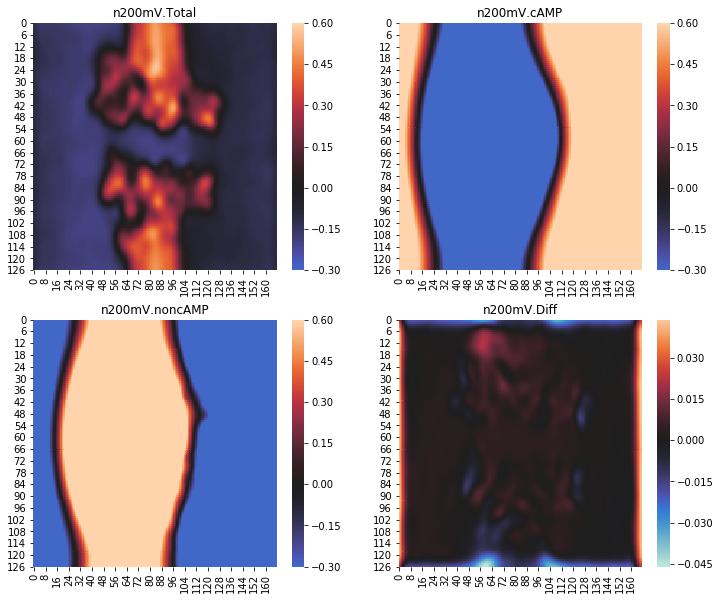

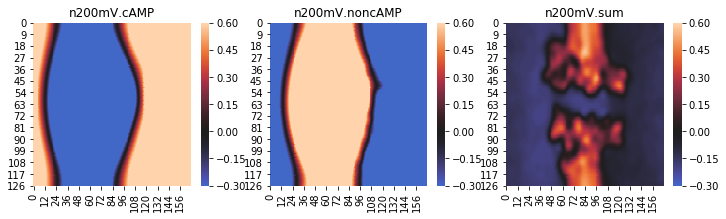

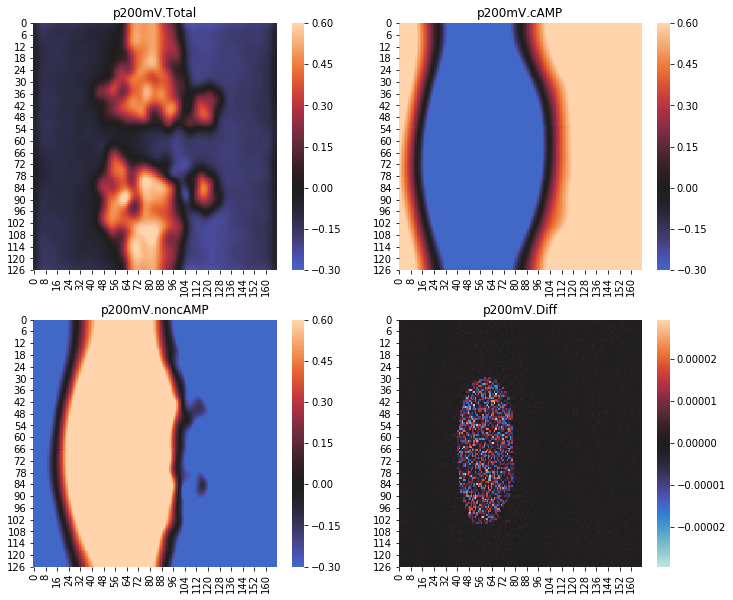

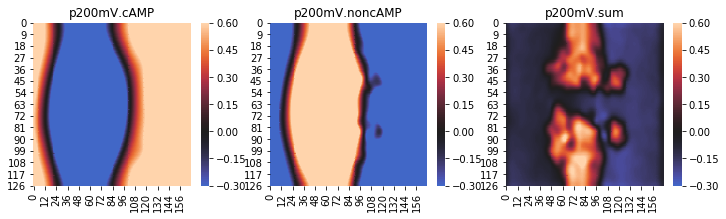

In [227]:
for simName in ['n200mV','p200mV']:
    diff_grid=pmeDict[simName+'.Total']-pmeDict[simName+'.cAMP']-pmeDict[simName+'.noncAMP']
    kb=8.617333262E-5
    tSim=310.15
    kbT=kb*tSim

    ymid=int(np.round(diff_grid.grid.shape[1]/2))
    gVol=np.product(diff_grid.grid.shape)


    fig,axs=plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(10)

    gridData=pmeDict[simName+'.Total'].grid
    pmeTotal_mean=np.mean(gridData)
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[0,0])

    axs[0,0].set_title(simName+'.Total')

    gridData=pmeDict[simName+'.cAMP'].grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[0,1])

    axs[0,1].set_title(simName+'.cAMP')

    gridData=pmeDict[simName+'.noncAMP'].grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[1,0])

    axs[1,0].set_title(simName+'.noncAMP')

    gridData=diff_grid.grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,#vmin=-.00003,vmax=.00006,
                ax=axs[1,1])

    axs[1,1].set_title(simName+'.Diff')

    plt.show()


    fig,axs=plt.subplots(1,3)
    fig.set_figwidth(12)
    fig.set_figheight(3)

    gridData=pmeDict[simName+'.cAMP'].grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[0])
    axs[0].set_title(simName+'.cAMP')

    gridData=pmeDict[simName+'.noncAMP'].grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[1])
    axs[1].set_title(simName+'.noncAMP')

    sum_grid=pmeDict[simName+'.cAMP']+pmeDict[simName+'.noncAMP']
    gridData=sum_grid.grid
    gridData=gridData-np.mean(gridData)
    plotData=gridData[:,ymid,:]*kbT
    sns.heatmap(plotData,
                center=0,vmin=-.3,vmax=.6,
                ax=axs[2])
    axs[2].set_title(simName+'.sum')

    plt.show()

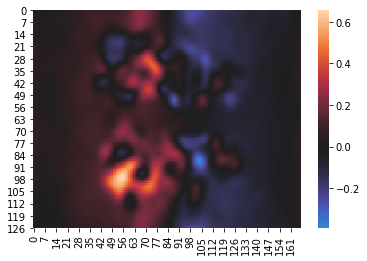

In [259]:
sns.heatmap(kbT*(pmeDict['p200mV.Total'].grid-pmeDict['n200mV.Total'].grid)[:,ymid,:],center=0)
plt.show()

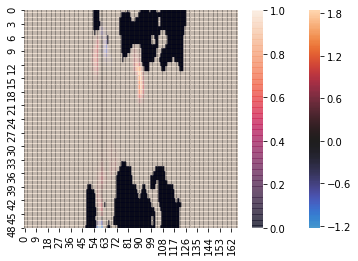

In [272]:
kT=0.0019872041*310.15
xmid=int(np.round(resampledDensityDict['n200mV.cAMP'].grid.shape[0]/2))
ymid=int(np.round(resampledDensityDict['n200mV.cAMP'].grid.shape[1]/2))
sns.heatmap(
    (
        resampledDensityDict['n200mV.cAMP']-resampledDensityDict['p200mV.cAMP']
    ).grid[(xmid-25):(xmid+25),ymid,:],
    center=0
)
sns.heatmap(resampledDensityDict['n200mV.Solvent'].grid[(xmid-25):(xmid+25),ymid,:]>.1,alpha=.5)
plt.show()

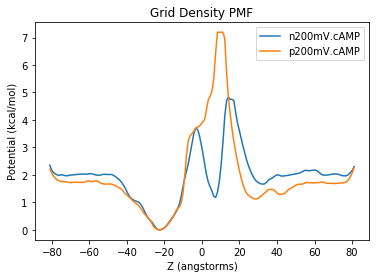

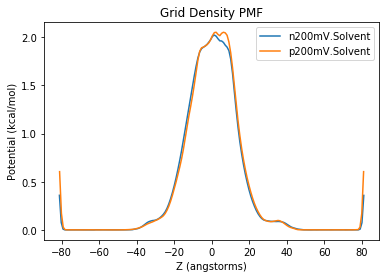

In [296]:
kT=0.0019872041*310.15
gVol=np.product(resampledDensityDict['n200mV.cAMP'].grid.shape)
for densityName in ['n200mV.cAMP','p200mV.cAMP']:
    densityGrid=resampledDensityDict[densityName]
    gVol=np.product(densityGrid.grid.shape)
    densityData=densityGrid.grid
    densityData=densityData/np.sum(densityData)
    pmfData=-kT*np.log(
        np.array(
            list(
                map(lambda x: np.max([1./gVol,x]),
                    np.nansum(densityData,axis=(0,1))
                   )
            )
        )
    )
    pmfData=pmfData-np.min(pmfData)
    pmfCoords=np.arange(densityData.shape[2])*densityGrid.delta[2]+densityGrid.origin[2]
    sns.lineplot(pmfCoords,
                 pmfData,
                 label=densityName)
plt.title("Grid Density PMF")
plt.xlabel('Z (angstorms)')
plt.ylabel('Potential (kcal/mol)')
plt.show()

kT=0.0019872041*310.15
for densityName in ['n200mV.Solvent','p200mV.Solvent']:
    densityGrid=resampledDensityDict[densityName]
    gVol=np.product(densityGrid.grid.shape)
    densityData=densityGrid.grid
    densityData=densityData/np.sum(densityData)
    pmfData=-kT*np.log(
        np.array(
            list(
                map(lambda x: np.max([1./gVol,x]),
                    np.nansum(densityData,axis=(0,1))
                   )
            )
        )
    )
    pmfData=pmfData-np.min(pmfData)
    pmfCoords=np.arange(densityData.shape[2])*densityGrid.delta[2]+densityGrid.origin[2]
    sns.lineplot(pmfCoords,
                 pmfData,
                 label=densityName)
plt.title("Grid Density PMF")
plt.xlabel('Z (angstorms)')
plt.ylabel('Potential (kcal/mol)')
plt.show()

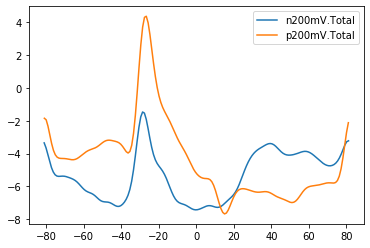

In [288]:
for pmeName in ['n200mV.Total','p200mV.Total']:
    pmeGrid=pmeDict[pmeName]
    pmeData=pmeGrid.grid[xmid,ymid,:]
    pmeCoords=np.arange(pmeGrid.grid.shape[2])*pmeGrid.delta[2]+pmeGrid.origin[2]
    sns.lineplot(pmeCoords,pmeData,label=pmeName)
plt.show()